<a href="https://colab.research.google.com/github/robpalinic/springboard-capstone-two/blob/main/Seattle_AirBnb_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

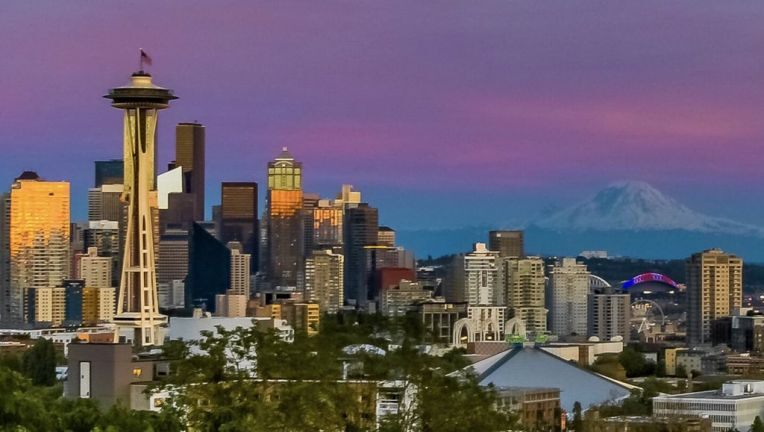

# **Optimizing the Seattle AirBnB market**

---


Hosts that have high occupancy rates (above 90%) may be underpricing their units, but may not know an ideal price to charge. Conversely, the rest of the market may have low occupancy due to factors under their control that they do not know about.

The goal is to create a model that can inform decision making to maximize overall revenue. The dataset will be segmented into neighbourhood and rental type, then further divided into two by high occupancy vs. regular units.

A model will then be trained on the non-90% occupancy units, or 'regular' units', to identify price and which features lead to higher prices. Ideally, these features will be controllable by the host. Both linear regression and random forest models will be built, with the most accurate model being chosen.

This model will then be applied to the high occupancy hosts and determine if they are priced well or below-market.

There will be two outputs from this project: recommended prices for high occupancy hosts, and potential improvements for regular hosts. The overall market will then be analyzed with potential changes.

## **Step 1: Data Collection**

---


Data was sourced from Kaggle, which had a dataset for one year for Seattle by listings from the year 2016.  Included is a separate file for reviews which is not needed for this analysis.

An important portion of this analysis will revolve around occupancy rates, which are not part of the data set. Analysis from insideairbnb.com, which analyzes AirBnB data, suggests that half of the guests leave reviews. Some data munging will most likely be necessary based on average reviews per month.

The original data: https://www.kaggle.com/airbnb/seattle

The Occupancy Model: http://insideairbnb.com/about.html#The%20Occupancy%20Model

In [1403]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

pd.set_option('display.max_colwidth',1000)

In [1404]:
listings = pd.read_csv('/content/drive/MyDrive/Seattle AirBnb/listings.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Seattle AirBnb/reviews.csv')

## **Step 2:  Data Definition**

---


Here we will get an idea of the data we have.  How many records, fields, data types, and what we are going to be able to use.

In our first step, we find that there are 92 fields (92!) and 3,818 records.  The fields can be broken into a few broad groups:
Host Information

*   Home Description and Characteristics
*   Reviews
*   Location
*   Pricing
*   Rules
*   Scraping information



Many of these fields are superfluous to building a model, or are redundant (three fields for neighbourhood, plus latitude and longtitude, etc.)  The obvious fields will be removed immediately during data cleansing, while the redundant fields will be examined and culled.












In [1405]:
listings.shape

(3818, 92)

In [1406]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [1407]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,"Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV, DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo. The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bars, and restaurants. There i...","Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV, DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo. The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bars, and restaurants. There i...",none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/cfe47d69_original.jpg?interpolation=lanczos-none&size=large_cover&output-format=jpg&output-quality=70,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a small landscape business. My life revolves around beauty wherever I find it or create it. I grew up in Seattle and love this city for the people, it's natural beauty and don't know anywhere else I would rather call home. I love to travel and try to do so as much as possible and am excited to be a part of the airbnb commun

In [1408]:
reviews.head(1)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to everything!


In [1409]:
last= pd.to_datetime(reviews['date'])
reviews['year'] = last.dt.year
reviews['year'].value_counts()

2015    52493
2014    20365
2013     7077
2012     3251
2011     1169
2010      254
2016      223
2009       17
Name: year, dtype: int64

In [1410]:
reviews['month'] = last.dt.month
reviews['month'].value_counts()

8     13018
9     11677
7     10503
10     8955
6      8544
11     6665
5      5854
12     5732
4      4233
3      4158
1      2867
2      2643
Name: month, dtype: int64

In [1411]:
reviews = reviews[reviews['year']==2015]
reviews = reviews[reviews['month'].between(6,10)]
review_counts = pd.DataFrame(reviews.groupby('listing_id')['id'].count())
review_counts['listing_id'] = review_counts.index
review_counts.rename(columns={'listing_id':'id', 'id':'reviews'}, inplace=True)
review_counts.head(1)

,reviews,id
listing_id,,
4291,8,4291


The review file we will use will be called review_counts, and will be for the months of June to October in 2015 and contains the number of reviews by listing.


## **Step 3:  Data Cleansing**

---


The purpose of this step is identify records missing, unnecessary fields, fields that need formatting, and any categorical data which require changes.  I will be taking three different actions: removing fields, removing records, or altering records.

Cleansing will consist of several steps.  
, dealing with missing data, formatting of data, and outliers.

*   Removing unneeded fields
*   Formatting of data
*   Dealing with missing data
*   Removing Duplicates
*   Outliers




**3.0 Merge the listings file with review_counts**

In [1412]:
listings.shape

(3818, 92)

In [1413]:
listings = pd.merge(listings, review_counts)

**3.1 Initial fields to remove**
Any field that is redundant (geographic data), text heavy or about the host will be removed as it will not assist analysis.


In [1414]:
listings['amenities'].head(10)
#Looks to be TV, Internet, etc.  Will Remove this

0                                                                                                                                                                                     {TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}
1                                                    {TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}
2    {TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}
3                                                                                                            

In [1415]:
remove_fields = ['amenities', 'host_id', 'host_has_profile_pic', 'zipcode', 'market', 'smart_location', 'country_code', 
                 'country', 'longitude', 'latitude', 'is_location_exact', 'host_neighbourhood',
                 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
                 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 
                 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_since', 
                 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count', 
                 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'street', 'city', 
                 'state','calendar_updated', 'has_availability', 'calendar_last_scraped', 'requires_license', 
                 'license', 'jurisdiction_names', 'calculated_host_listings_count', 'availability_90', 'availability_60', 'availability_30']

In [1416]:
listings = listings.drop(remove_fields, axis=1)
listings.shape

(2721, 42)

**3.2 Formatting changes**

Several fields with dollar amounts need to be changed to float, while the percentage needs to be converted to float.

In [1417]:
fields_to_float = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

for f in fields_to_float:
  listings[f] = pd.to_numeric(listings[f].str.strip(',$'), errors='coerce')

In [1418]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'), errors='coerce')/100

**3.3 Dealing with missing data**
	

In [1419]:
listings.isna().sum().sort_values(ascending=False)

square_feet                         2642
monthly_price                       2636
weekly_price                        1516
security_deposit                    1362
cleaning_fee                         636
host_acceptance_rate                 414
host_response_time                   267
host_response_rate                   267
neighbourhood                        249
review_scores_checkin                 12
review_scores_accuracy                12
review_scores_cleanliness             12
review_scores_value                   11
bathrooms                             11
review_scores_communication           10
review_scores_location                10
review_scores_rating                   8
bedrooms                               3
host_is_superhost                      0
beds                                   0
room_type                              0
accommodates                           0
property_type                          0
neighbourhood_group_cleansed           0
neighbourhood_cl

**3.3.1 Square Feet**

Just about every record is missing this field.  Drop the field.

In [1420]:
listings = listings.drop(['square_feet'], axis=1)

**3.3.2 Weekly and Monthly Rent**
Not all hosts have entered a weekly or monthly price.  For now, just multiply by 7 for weekly and 30 for monthly.

In [1421]:
missing_rent = listings[listings['weekly_price']!=listings['weekly_price']][['price', 'weekly_price', 'monthly_price']]
missing_rent.head()

,price,weekly_price,monthly_price
0,85.0,NaN,NaN
1,150.0,NaN,NaN
2,975.0,NaN,NaN
3,450.0,NaN,NaN
8,150.0,NaN,NaN


In [1422]:
listings['weekly_price'].fillna(listings['price']*7, inplace=True)
listings['monthly_price'].fillna(listings['price']*30, inplace=True)

**3.3.3 Security Deposit and Cleaning Fee**

Both of these fields should be set to zero for no fee.

In [1423]:
listings['security_deposit'].fillna(0, inplace=True)
listings['cleaning_fee'].fillna(0, inplace=True)

**3.3.4 Host Acceptance Rate**

In [1424]:
#Investigate acceptance rate field
print(listings['host_acceptance_rate'].head())
listings['host_acceptance_rate'].value_counts()

#This field is either 100%, or nothing. Will drop this field.

0    100%
1    100%
2    100%
3     NaN
4     NaN
Name: host_acceptance_rate, dtype: object


100%    2306
0%         1
Name: host_acceptance_rate, dtype: int64

In [1425]:
listings = listings.drop('host_acceptance_rate', axis=1)

**3.3.5 Review Score**

It looks like if some review scores are missing they are all missing.  Best to remove all of these records.

In [1426]:
listings[listings['review_scores_checkin'].isna()].head()

,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
269,8207848,within a few hours,0.99,f,Fremont,Wallingford,Other neighborhoods,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,259.0,1813.0,7770.0,0.0,155.0,1,0.0,3,1125,365,1,2015-09-16,2015-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,strict,f,f,0.27,1
534,6796336,NaN,NaN,f,University District,University District,University District,House,Private room,1,1.5,1.0,1.0,Real Bed,30.0,150.0,900.0,0.0,0.0,1,0.0,1,1125,180,1,2015-08-29,2015-08-29,80.0,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.23,1
560,7536074,within an hour,1.00,f,University District,University District,University District,Apartment,Entire home/apt,2,1.0,2.0,2.0,Real Bed,185.0,1295.0,5550.0,0.0,0.0,1,0.0,1,1125,365,1,2015-07-25,2015-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.18,1
573,7807658,within a day,1.00,f,University District,University District,University District,Apartment,Shared room,2,1.0,1.0,2.0,Real Bed,118.0,826.0,3540.0,0.0,0.0,1,0.0,1,1125,365,1,2015-08-16,2015-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.21,1
1047,9012948,within a day,1.00,f,NaN,International District,Downtown,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,130.0,910.0,3900.0,0.0,0.0,1,0.0,1,1125,72,1,2015-10-31,2015-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.45,1


In [1427]:
listings = listings[listings['review_scores_checkin'].notnull()]
listings.reset_index(inplace=True)
listings.shape

(2709, 41)

**3.3.6  Host Response Rate and Time**

Unknown why this data is missing, many of these listings are active.  I have to assume they just didn't have someone reach out.  Set these to 100% and 'Within an hour'

In [1428]:
listings['host_response_time'].head()

0    within a few hours
1        within an hour
2    within a few hours
3        within an hour
4                   NaN
Name: host_response_time, dtype: object

In [1429]:
listings[listings['host_response_time'].isnull()].head(2)

,index,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
4,4,5956968,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,120.0,800.0,3600.0,0.0,40.0,1,30.0,1,6,302,17,2015-06-11,2015-09-28,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2.45,17
7,7,4948745,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,90.0,500.0,2700.0,0.0,0.0,1,0.0,3,1125,341,8,2015-06-22,2015-08-17,97.0,10.0,9.0,10.0,9.0,10.0,10.0,f,strict,f,f,1.22,8


In [1430]:
listings['host_response_rate'].fillna(1, inplace=True)
listings['host_response_time'].fillna('within an hour', inplace=True)

**3.3.7 Last Review Time**
The data for the last review shows most listings had their reviews in 2015 or 2016.  Best to remove the older listings from 2014 and before.

In [1431]:
last= pd.to_datetime(listings['last_review'])
listings['year'] = last.dt.year
listings['year'].value_counts()

2015    2543
2016     166
Name: year, dtype: int64

In [1432]:
listings = listings[listings['year']>=2015]
listings['year'].value_counts()

2015    2543
2016     166
Name: year, dtype: int64

In [1433]:
listings = listings.drop(['first_review', 'last_review', 'year', 'index'], axis=1)

**3.3.9 Neighborhood**
The neighborhood field is missing values.  Luckily, there are two other neighborhood fields.  The neighborhood group cleansed field has 17 unique entries, while neighbourhood cleansed has 87.  I will be keeping the group field and dropping the other two.

In [1434]:
listings['neighbourhood_group_cleansed'].nunique()

17

In [1435]:
listings['neighbourhood_cleansed'].nunique()

87

In [1436]:
listings = listings.drop(['neighbourhood', 'neighbourhood_cleansed'], axis=1)
listings.shape

(2709, 36)

**3.3.10 Bathrooms, bedrooms, beds**

It is hard to believe there are no bathrooms, bedrooms, or beds in a listing.  Where the data is missing, we will enter a value of 1.

In [1437]:
listings.reset_index(drop=True, inplace=True)
listings['beds'].fillna(1, inplace=True)
listings['bedrooms'].fillna(1, inplace=True)
listings['bathrooms'].fillna(1, inplace=True)

In [1438]:
listings.isna().sum().sort_values(ascending=False)

review_scores_value                 1
reviews                             0
bathrooms                           0
monthly_price                       0
weekly_price                        0
price                               0
bed_type                            0
beds                                0
bedrooms                            0
accommodates                        0
cleaning_fee                        0
room_type                           0
property_type                       0
neighbourhood_group_cleansed        0
host_is_superhost                   0
host_response_rate                  0
host_response_time                  0
security_deposit                    0
guests_included                     0
reviews_per_month                   0
review_scores_checkin               0
require_guest_phone_verification    0
require_guest_profile_picture       0
cancellation_policy                 0
instant_bookable                    0
review_scores_location              0
review_score

**3.3.11 Recap:  What is the state of the data**
After all this, there is only one missing value in the review_scores_value field.  All of its reviews are 10s, so we will manually change the missing value to 10.

We are left with 3082 records in 35 fields.

In [1439]:
listings.shape

(2709, 36)

In [1440]:
listings.isna().sum().sort_values(ascending=False)

review_scores_value                 1
reviews                             0
bathrooms                           0
monthly_price                       0
weekly_price                        0
price                               0
bed_type                            0
beds                                0
bedrooms                            0
accommodates                        0
cleaning_fee                        0
room_type                           0
property_type                       0
neighbourhood_group_cleansed        0
host_is_superhost                   0
host_response_rate                  0
host_response_time                  0
security_deposit                    0
guests_included                     0
reviews_per_month                   0
review_scores_checkin               0
require_guest_phone_verification    0
require_guest_profile_picture       0
cancellation_policy                 0
instant_bookable                    0
review_scores_location              0
review_score

In [1441]:
listings['review_scores_value'] = listings['review_scores_value'].fillna(10)

**3.5 Dedupe data**

It appears that there were no duplicates.

In [1442]:
listings.drop_duplicates()
print(listings.shape)

(2709, 36)


**3.6 Check for outliers.**

Taking the minimum and maximum of each field, nothing sticks out as being too high or too low, except for one home with a price of $999.  It doesn't appear to be an error, so it is left in.  Perhaps a 'luxury' condo.

I did notice that a property type had a yurt.  I investigated and found some other weird property types (dorm, treehouse) that won't help with the modeling. These will be removed, leaving only House and Apartment.  Townhomes will be rolled up into House, while Condo and Loft will roll up into Apartment.

When we look at listings by neighbourhood, we find some neighbourhoods just have too few listings to justify analysis.  We can remove these from the dataset.

In [1443]:
listings.describe()

,id,host_response_rate,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,reviews
count,2.709000e+03,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000,2709.000000
mean,4.755616e+06,0.956574,3.377261,1.251569,1.306755,1.733481,128.013658,869.667036,3822.349206,125.856774,46.647102,1.723145,11.488372,2.089701,748.578811,253.669620,30.557032,94.575120,9.655223,9.569214,9.800664,9.824659,9.605389,9.454780,2.208767,12.034330
std,2.624189e+06,0.108025,1.974584,0.572417,0.864550,1.142953,89.939444,637.227918,2715.387363,163.574874,49.432304,1.317191,18.201694,2.094976,1975.870523,119.287402,41.935311,5.799963,0.610705,0.742335,0.542969,0.480688,0.615878,0.693851,1.854685,11.217433
min,4.291000e+03,0.170000,1.000000,0.000000,0.000000,1.000000,25.000000,161.000000,500.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,4.000000,4.000000,2.000000,2.000000,4.000000,4.000000,0.040000,1.000000
25%,2.526129e+06,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,500.000000,2250.000000,0.000000,10.000000,1.000000,0.000000,1.000000,31.000000,150.000000,6.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.760000,3.000000
50%,5.021969e+06,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,700.000000,3000.000000,95.000000,35.000000,1.000000,5.000000,2.000000,1125.000000,314.000000,16.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.690000,8.000000
75%,7.071222e+06,1.000000,4.000000,1.000000,2.000000,2.000000,150.000000,1043.000000,4500.000000,200.000000,70.000000,2.000000,20.000000,2.000000,1125.000000,359.000000,37.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.160000,18.000000
max,9.110730e+06,1.000000,16.000000,5.000000,7.000000,15.000000,999.000000,6993.000000,29970.000000,995.000000,300.000000,13.000000,300.000000,31.000000,100000.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000,73.000000


In [1444]:
listings[listings['price']==999]

,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
862,3345341,within a few hours,1.0,f,Downtown,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,999.0,6993.0,29970.0,95.0,85.0,1,10.0,1,31,0,54,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,moderate,f,f,2.89,6


In [1445]:
listings['property_type'].value_counts()

House              1262
Apartment          1206
Townhouse            68
Condominium          57
Loft                 29
Bed & Breakfast      24
Cabin                20
Other                15
Camper/RV            10
Bungalow              6
Tent                  4
Boat                  3
Treehouse             2
Yurt                  1
Chalet                1
Dorm                  1
Name: property_type, dtype: int64

In [1446]:
listings.loc[(listings['property_type'] == 'Townhouse'),'property_type'] = 'House'
listings.loc[(listings['property_type'] == 'Bungalow'),'property_type'] = 'House'

listings.loc[(listings['property_type'] == 'Condominium'),'property_type'] = 'Apartment'
listings.loc[(listings['property_type'] == 'Loft'),'property_type'] = 'Apartment'

to_drop = ['Bed & Breakfast', 'Cabin', 'Other', 'Camper/RV', 'Tent', 'Boat', 'Dorm', 'Treehouse', 'Chalet', 'Yurt']

listings = listings[~listings['property_type'].isin(to_drop)]

In [1447]:
listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    536
Downtown               383
Capitol Hill           367
Central Area           272
Queen Anne             214
Ballard                168
West Seattle           140
Rainier Valley         102
Beacon Hill             85
University District     69
Northgate               59
Cascade                 53
Delridge                53
Lake City               47
Magnolia                39
Seward Park             35
Interbay                 6
Name: neighbourhood_group_cleansed, dtype: int64

In [1448]:
neighbourhood_change = ['Interbay', 'Seward Park', 'Magnolia', 'Lake City', 'Northgate', 'Cascade', 'Delridge']

listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].replace([neighbourhood_change],'Other neighborhoods')

listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    828
Downtown               383
Capitol Hill           367
Central Area           272
Queen Anne             214
Ballard                168
West Seattle           140
Rainier Valley         102
Beacon Hill             85
University District     69
Name: neighbourhood_group_cleansed, dtype: int64

I'm worried about the prevalence of price outliers skewing results.  I will drop everything above 400 as there seems to be other factors driving those prices. Turns out there were only 48 listings above 400.

In [1449]:
print(listings.shape)
listings = listings[listings['price']<=400]
print(listings.shape)

(2628, 36)
(2584, 36)


**3.6 Final Data Frame**

We are now left with 35 fields and 2947 records.  This represents ten Seattle neighbourhoods, broken down into homes or apartments.


In [1450]:
listings.shape

(2584, 36)

In [1451]:
listings.head()

,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
0,241032,within a few hours,0.96,f,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,595.0,2550.0,0.0,0.0,2,5.0,1,365,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,4.07,26
1,953595,within an hour,0.98,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,1050.0,4500.0,100.0,40.0,1,0.0,2,90,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,1.48,17
4,5956968,within an hour,1.00,f,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,120.0,800.0,3600.0,0.0,40.0,1,30.0,1,6,302,17,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2.45,17
5,1909058,within an hour,1.00,t,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,80.0,575.0,2400.0,150.0,0.0,1,10.0,3,14,346,58,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,2.46,18
7,4948745,within an hour,1.00,f,Queen Anne,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,90.0,500.0,2700.0,0.0,0.0,1,0.0,3,1125,341,8,97.0,10.0,9.0,10.0,9.0,10.0,10.0,f,strict,f,f,1.22,8




## **4.  Exploratory Data Analysis**

---



**4.1 Correlation between fields**

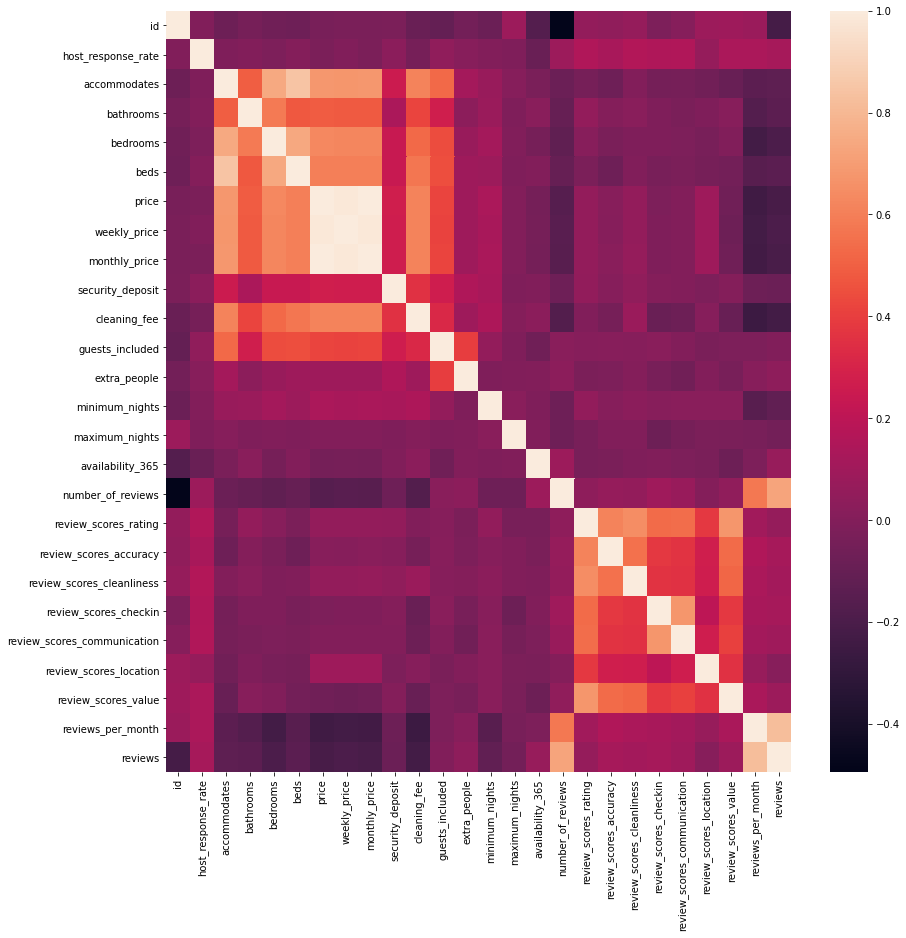

In [1452]:
plt.figure(figsize=(14,14))
sns.heatmap(listings.corr())
plt.show()

No surprise, fields denoting the size of the dwelling show a high correlation, as does price.  Interestingly, cleaning fee is also highly correlated.  Another cluster of highly correlated variables are around the rview scores (except location).

Surprisingly, there does not appear to be any correlation between price and reviews scores. This is surprising, and needs a closer look.

---



**4.2 Price against review scores.**

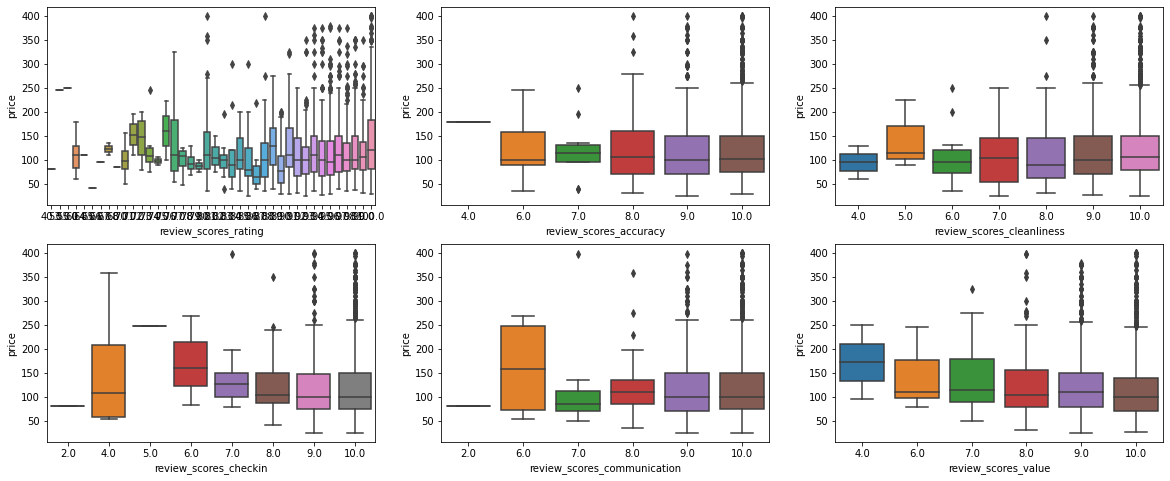

In [1453]:
listing_reviews = ['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 
           'review_scores_checkin', 'review_scores_communication', 'review_scores_value']

plt.figure(figsize=(20, 8))
plt.ylabel('Price')
i=1

for r in listing_reviews:
  plt.subplot(2, 3, i)
  sns.boxplot(x=listings[r], y=listings['price'])
  plt.xlabel(r)
  i+=1
plt.show()


It does appear that there is some correlation between review scores and price, with the most expensive listings tending to also have the best reviews and the cheaper listings have poorer reviews.  However, there are also many well reviewed homes that are cheap.  This may not be the best predictor.

---



**4.3 Let's compare pricing for homes vs apartments, and see if there is a difference.**

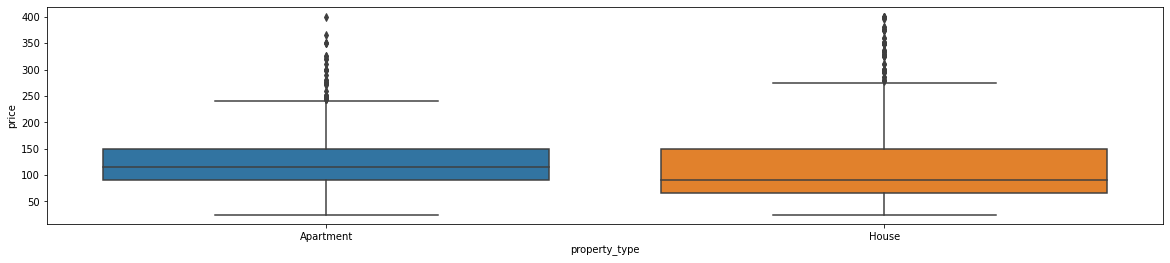

In [1454]:
plt.figure(figsize=(20,4))
sns.boxplot(x=listings["property_type"], y=listings["price"] );
plt.show()

Houses have a wider range of prices, but both apartments and houses have extremely pricey outliers at the high end of the range.  These may be super luxury types of homes, perhaps worth taking out.  Also, my assumption is that homes will be in suburbs (cheaper) while apartments will be in centralized areas.

**4.4 Now let's compare prices by neighbourhood.**

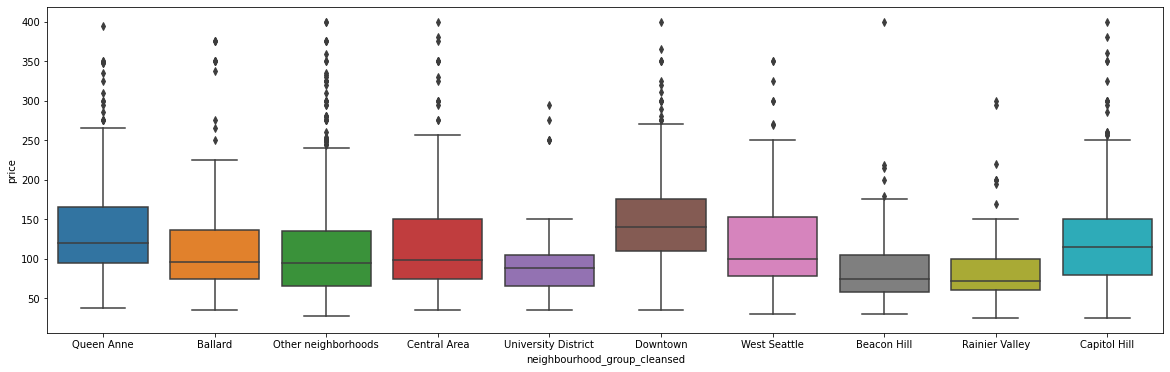

In [1455]:
plt.figure(figsize=(20,6))
sns.boxplot(x=listings["neighbourhood_group_cleansed"], y=listings["price"] );
plt.show()

It's making sense, with downtown neighbourhoods being fairly expensive and the university district being cheap.  Each neighbourhood has a noticeable number of outliers.  

**4.5 Finally, let's the reviews per month column against listings.**

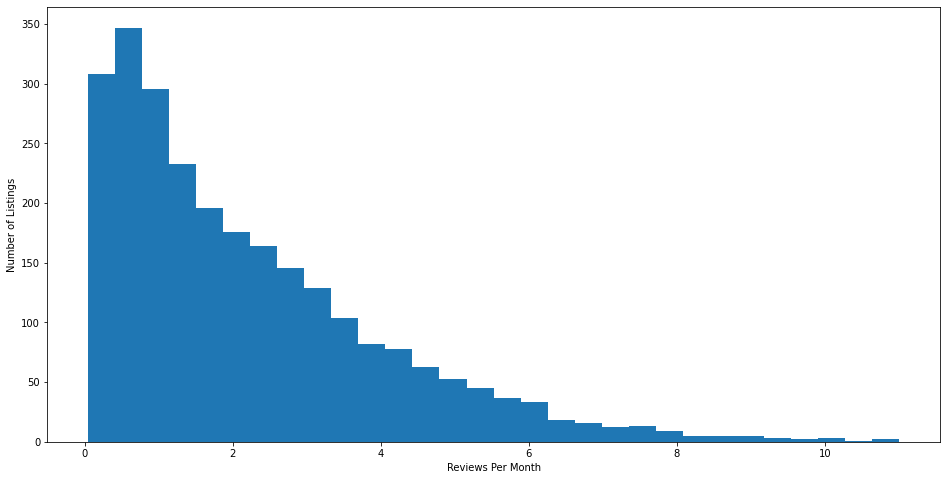

In [1456]:
plt.figure(figsize=(16,8))
plt.ylabel('Number of Listings')
plt.xlabel('Reviews Per Month')
plt.hist(listings['reviews_per_month'], bins=30)
plt.show()

This is interesting.  The idea of using a proxy of 50% of stays result in a review may be overstated.  Most listings have an average of 2 or less reviews.  I might need to go to the reviews file and use one month worth of data to see if I can get a more accurate count.  I don't know how the average reviews per month was calculated, as it could be number of reviews over a fixed time period, thereby underreporting the reviews.  Best to use a count from the reviews file. 

**4.6 Bedroom count and price.**

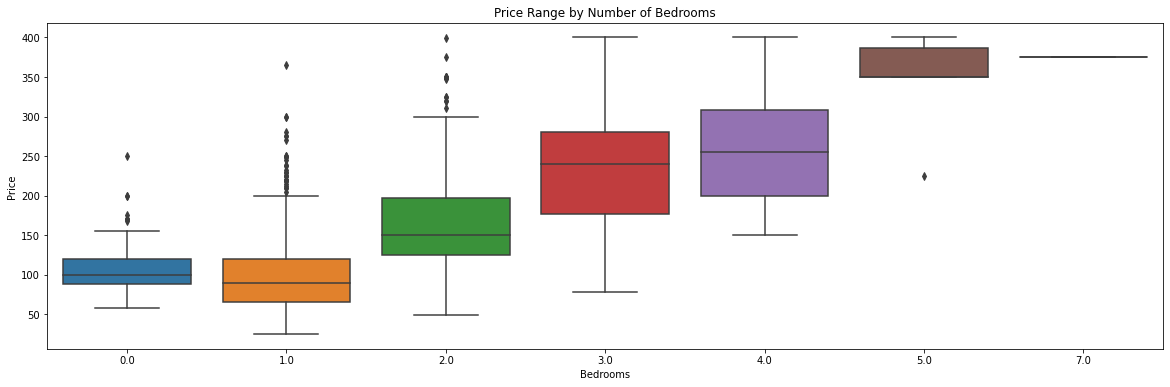

In [1457]:
plt.figure(figsize=(20,6))
plt.title('Price Range by Number of Bedrooms')
sns.boxplot(x=listings['bedrooms'], y=listings["price"] )
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

Not surprising that more bedrooms result in a higher price.  The lowest tier is zero bedrooms, but this is most likely studio apartments that are a combination bedroom, kitchen and living room.

**4.7  Reviews per month vs review count from Reviews file.**

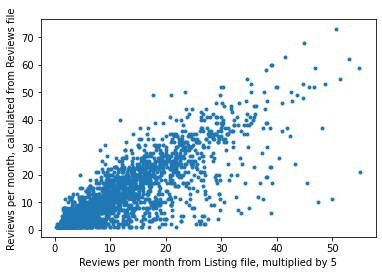

In [1458]:
plt.plot(listings['reviews_per_month']*5, listings['reviews'], linestyle='', marker='.')
plt.xlabel('Reviews per month from Listing file, multiplied by 5')
plt.ylabel('Reviews per month, calculated from Reviews file')
plt.show()

The original reviews_per_month correlates well with reviews, but not exactly.  I will use the new count as I feel it is more accurate.

In [1459]:
listings.drop('reviews_per_month', axis=1, inplace=True)

**4.7 Review count against listings.**

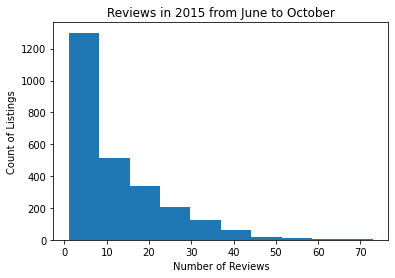

In [1460]:
plt.title('Reviews in 2015 from June to October')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Listings')
plt.hist(listings['reviews'])
plt.show()

Interesting that out of 150 possible days, most listings had ten or fewer reviews.  Assuming that the average stay is 5 days, we would still see the vast majority of listings not fully booked.

In [1461]:
listings[listings['reviews']>=27]['id'].count()

284

In [1462]:
listings[listings['reviews']<27]['id'].count()

2300

Assuming an average stay of 5 days, anything listing with over 27 listings can be considered over 90% occupied, by taking 150 potential rental days, dividing by 5 months to get 30 potential listings.  This gives us 284 listings out of 2584, or roughly 11% of listings.  



---


**4.8 EDA Conclusion**

We've explored the data and found that is in good shape.  We have identified pricing by ratings, neighbourhood, bedrooms, and house/apartment.  There is still a wide amount of variability in pricing, as well as occupancy rates as calculated from rating counts.  We're in great shape for the next stage of modeling.